In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [123]:
# 1. Configuración y Carga de Datos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [124]:
torch.manual_seed(30)
np.random.seed(30)

In [125]:
# Cargar dataset y scalers
df = pd.read_csv('data/processed/Dataset_PVPC_Normalizado.csv')
scaler_features = joblib.load('artifacts/scaler_features.pkl')
scaler_target = joblib.load('artifacts/scaler_target.pkl')
df['price_lag_1'] = df['price'].shift(1)
df['price_lag_24'] = df['price'].shift(24)
df['price_lag_168'] = df['price'].shift(168) # Misma hora, semana anterior
df.dropna(inplace=True)

d:\pablo\miniconda3\envs\ai\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [126]:
# visualización del df
df

,price,temperature_2m (°C),cloud_cover (%),wind_speed_100m (km/h),shortwave_radiation (W/m²),apparent_temperature (°C),direct_radiation (W/m²),diffuse_radiation (W/m²),wind_gusts_10m (km/h),relative_humidity_2m (%),hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,no_laborable,price_lag_1,price_lag_24,price_lag_168
168,0.363691,0.055248,0.192766,0.339216,0.000000,0.046589,0.000000,0.000000,0.190136,0.742481,0.500000,1.000000,0.500000,1.000000,0.75,0.933013,0.0,0.371353,0.372190,0.306377
169,0.356933,0.044494,0.181489,0.315398,0.000000,0.036844,0.000000,0.000000,0.179591,0.745927,0.629410,0.982963,0.500000,1.000000,0.75,0.933013,0.0,0.363691,0.367907,0.305240
170,0.347230,0.051438,0.218723,0.299026,0.000000,0.043086,0.000000,0.000000,0.185083,0.724311,0.750000,0.933013,0.500000,1.000000,0.75,0.933013,0.0,0.356933,0.359509,0.300254
171,0.345523,0.037549,0.208936,0.282654,0.000000,0.031643,0.000000,0.000000,0.166850,0.735589,0.853553,0.853553,0.500000,1.000000,0.75,0.933013,0.0,0.347230,0.355494,0.303199
172,0.356665,0.024582,0.275745,0.260876,0.000000,0.020530,0.000000,0.000000,0.157330,0.750313,0.933013,0.750000,0.500000,1.000000,0.75,0.933013,0.0,0.345523,0.355126,0.307582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8778,0.854390,0.142699,0.124255,0.125975,0.042631,0.162050,0.028531,0.054453,0.062720,0.757832,0.000000,0.500000,0.900969,0.801938,0.50,1.000000,0.0,0.834181,0.875468,0.688604
8779,0.842244,0.110927,0.130851,0.119141,0.000180,0.131775,0.000052,0.000402,0.024385,0.816103,0.017037,0.629410,0.900969,0.801938,0.50,1.000000,0.0,0.854390,0.900127,0.677998
8780,0.832675,0.087205,0.141915,0.122150,0.000000,0.107303,0.000000,0.000000,0.033575,0.848997,0.066987,0.750000,0.900969,0.801938,0.50,1.000000,0.0,0.842244,0.880956,0.649993
8781,0.646748,0.065757,0.176596,0.140460,0.000000,0.083653,0.000000,0.000000,0.051882,0.869674,0.146447,0.853553,0.900969,0.801938,0.50,1.000000,0.0,0.832675,0.669566,0.503011


In [127]:
# ✅ CORRECCIÓN 1: No excluimos 'price' de los features.
# La red NECESITA la curva de precios pasada para predecir el futuro.
feature_cols = list(df.columns)
X_data = df[feature_cols].values
y_data = df['price'].values

In [128]:
# 2. Secuencias
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x = X[i:(i + seq_length)] # Contiene historial hasta t-1 (incluyendo el precio)
        xs.append(x)
        ys.append(y[i + seq_length]) # El objetivo es t
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24
X_seq, y_seq = create_sequences(X_data, y_data, SEQ_LENGTH)

In [129]:
# ✅ CORRECCIÓN 2: División Train / Val / Test (70/15/15)
train_split = int(len(X_seq) * 0.70)
val_split = int(len(X_seq) * 0.85)

X_train, y_train = X_seq[:train_split], y_seq[:train_split]
X_val, y_val = X_seq[train_split:val_split], y_seq[train_split:val_split]
X_test, y_test = X_seq[val_split:], y_seq[val_split:]

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False)

In [130]:
# 3. Definición del Modelo Mejorado
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)

        # ✅ CORRECCIÓN 3: Arquitectura final más robusta
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))

        out = self.dropout(out[:, -1, :])
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Subimos hidden_size a 128 para procesar mejor la memoria a largo plazo
model = LSTMModel(input_size=len(feature_cols), hidden_size=128, num_layers=2, output_size=1).to(device)

In [131]:
# 4. Entrenamiento con Validación y Scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 Regularization
# ✅ CORRECCIÓN 4: Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

epochs = 75 # Puedes usar más épocas porque ahora validas
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Evaluar en Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item()

    avg_train = train_loss/len(train_loader)
    avg_val = val_loss/len(val_loader)
    scheduler.step(avg_val)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train:.5f} | Val Loss: {avg_val:.5f}")

Epoch [5/75] | Train Loss: 0.00446 | Val Loss: 0.00570
Epoch [10/75] | Train Loss: 0.00332 | Val Loss: 0.00472
Epoch [15/75] | Train Loss: 0.00305 | Val Loss: 0.00358
Epoch [20/75] | Train Loss: 0.00272 | Val Loss: 0.00409
Epoch [25/75] | Train Loss: 0.00249 | Val Loss: 0.00337
Epoch [30/75] | Train Loss: 0.00228 | Val Loss: 0.00343
Epoch [35/75] | Train Loss: 0.00221 | Val Loss: 0.00329
Epoch [40/75] | Train Loss: 0.00212 | Val Loss: 0.00330
Epoch [45/75] | Train Loss: 0.00206 | Val Loss: 0.00336
Epoch [50/75] | Train Loss: 0.00202 | Val Loss: 0.00325
Epoch [55/75] | Train Loss: 0.00205 | Val Loss: 0.00327
Epoch [60/75] | Train Loss: 0.00200 | Val Loss: 0.00326
Epoch [65/75] | Train Loss: 0.00203 | Val Loss: 0.00327
Epoch [70/75] | Train Loss: 0.00201 | Val Loss: 0.00326
Epoch [75/75] | Train Loss: 0.00205 | Val Loss: 0.00326


In [132]:
# visualizacion entrenamiento


In [133]:
# 5. Evaluación y Desnormalización
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.numpy())

In [134]:
# Invertir la normalización para obtener precios reales (Euros/MWh)
# scaler_target espera un array 2D
predictions_rescaled = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals_rescaled = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

In [135]:
# Métricas
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))

print("\n--- Resultados de la Evaluación ---")
print(f"MAE: {mae:.4f} €/MWh")
print(f"RMSE: {rmse:.4f} €/MWh")


--- Resultados de la Evaluación ---
MAE: 15.1437 €/MWh
RMSE: 19.5229 €/MWh


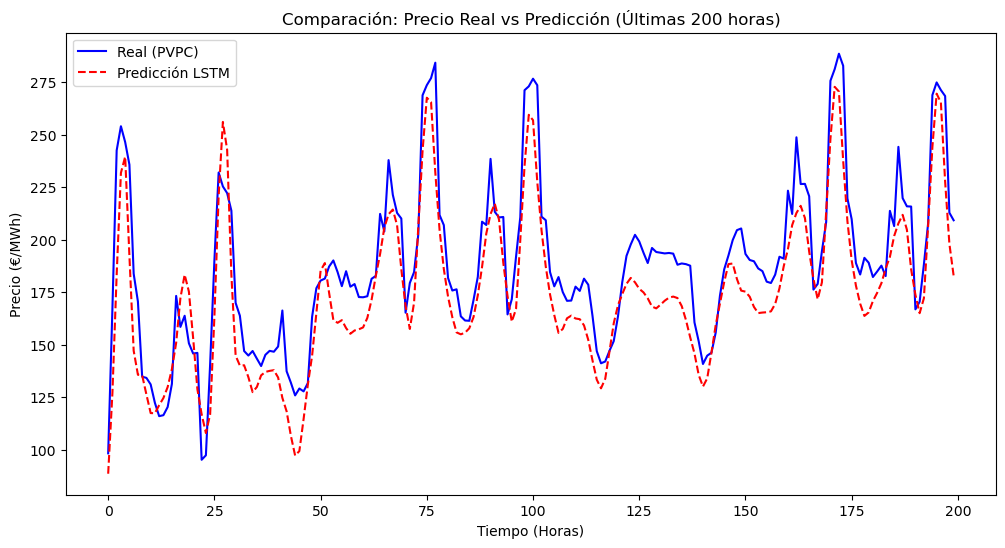

In [136]:
# 6. Visualización
plt.figure(figsize=(12, 6))
plt.plot(actuals_rescaled[-200:], label='Real (PVPC)', color='blue')
plt.plot(predictions_rescaled[-200:], label='Predicción LSTM', color='red', linestyle='--')
plt.title('Comparación: Precio Real vs Predicción (Últimas 200 horas)')
plt.xlabel('Tiempo (Horas)')
plt.ylabel('Precio (€/MWh)')
plt.legend()
plt.show() 

In [137]:
# # guardar el modelo
# torch.save(model.state_dict(), 'modelo_lstm_pvpc.pth')